#**Sequence-to-sequence**

# 資料下載

In [ ]:
!gdown --id '1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg' --output data.tar.gz
!tar -zxvf data.tar.gz
!mkdir ckpt
!ls

Downloading...
From: https://drive.google.com/uc?id=1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg
To: /content/data.tar.gz
5.83MB [00:00, 18.6MB/s]
cmn-eng/
cmn-eng/int2word_cn.json
cmn-eng/int2word_en.json
cmn-eng/preprocess/
cmn-eng/preprocess/build_dataset.py
cmn-eng/preprocess/build_dictionary.sh
cmn-eng/preprocess/cmn.txt
cmn-eng/preprocess/cn.txt
cmn-eng/preprocess/dict.txt.big
cmn-eng/preprocess/dict.txt.small
cmn-eng/preprocess/en.txt
cmn-eng/preprocess/en_code.txt
cmn-eng/preprocess/en_refine.txt
cmn-eng/preprocess/en_vocab.txt
cmn-eng/preprocess/tokenizer.py
cmn-eng/testing.txt
cmn-eng/training.txt
cmn-eng/validation.txt
cmn-eng/word2int_cn.json
cmn-eng/word2int_en.json
ckpt  cmn-eng  data.tar.gz  sample_data


# 下載和引入需要的 libraries

In [ ]:
%%capture
!pip3 install --user nltk

In [ ]:
%%capture
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms

import numpy as np
import sys
import os
import random
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算


# 資料結構

## 定義資料的轉換
- 將不同長度的答案拓展到相同長度，以便訓練模型

In [ ]:
import numpy as np
# self.transform = LabelTransform(max_output_len, self.word2int_en['<PAD>'])
class LabelTransform(object):
  def __init__(self, size, pad):
    self.size = size
    self.pad = pad

  def __call__(self, label):
    label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
    return label
# np.pad(array, pad_width, mode, **kwargs) 
# array 為填充目標
# pad_wdith 為各array需要填充的數目，此處只補後面不補前面
# constant 表示連續填充相同的值，constant_values為要填充的值

In [ ]:
import re
import json

class EN2CNDataset(data.Dataset):
  def __init__(self, root, max_output_len, set_name): 
    # train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'training')
    self.root = root
    self.word2int_cn, self.int2word_cn = self.get_dictionary('cn')
    self.word2int_en, self.int2word_en = self.get_dictionary('en')

    # 載入資料
    self.data = []
    with open(os.path.join(self.root, f'{set_name}.txt'), "r") as f: # f-string 可讓 set_name 直接代入
      for line in f:
        self.data.append(line)
    print (f'{set_name} dataset size: {len(self.data)}')

    self.cn_vocab_size = len(self.word2int_cn)
    self.en_vocab_size = len(self.word2int_en)
    self.transform = LabelTransform(max_output_len, self.word2int_en['<PAD>'])

  def get_dictionary(self, language):
    # 載入字典
    with open(os.path.join(self.root, f'word2int_{language}.json'), "r") as f:
      word2int = json.load(f)
    with open(os.path.join(self.root, f'int2word_{language}.json'), "r") as f:
      int2word = json.load(f)
    return word2int, int2word

  def __len__(self):
    return len(self.data)

  def __getitem__(self, Index):
    # 先將中英文分開
    sentences = self.data[Index]
    sentences = re.split('[\t\n]', sentences) ##### tab 及 換行符號，此處有待檢查
    sentences = list(filter(None, sentences)) ##### 此處有待檢查
    #print (sentences)
    assert len(sentences) == 2 
    # 確保長度為2，否則會報錯

    # 預備特殊字元
    BOS = self.word2int_en['<BOS>']
    EOS = self.word2int_en['<EOS>']
    UNK = self.word2int_en['<UNK>']

    # 在開頭添加 <BOS>，在結尾添加 <EOS> ，不在字典的 subword (詞) 用 <UNK> 取代
    en, cn = [BOS], [BOS]
    # 將句子拆解為 subword 並轉為整數
    sentence = re.split(' ', sentences[0])
    sentence = list(filter(None, sentence))
    #print (f'en: {sentence}')
    for word in sentence:
      en.append(self.word2int_en.get(word, UNK)) #  從字典中取出該字之編碼，若無則 return UNK = self.word2int_en['<UNK>']
    en.append(EOS)
    # 將句子拆解為單詞並轉為整數
    # e.g. < BOS >, we, are, friends, < EOS > --> 1, 28, 29, 205, 2

    sentence = re.split(' ', sentences[1])
    sentence = list(filter(None, sentence))
    #print (f'cn: {sentence}')
    for word in sentence:
      cn.append(self.word2int_cn.get(word, UNK))
    cn.append(EOS)

    en, cn = np.asarray(en), np.asarray(cn)

    # 用 <PAD> 將句子補到相同長度
    en, cn = self.transform(en), self.transform(cn)
    en, cn = torch.LongTensor(en), torch.LongTensor(cn)

    return en, cn


# 模型架構

## Encoder



In [ ]:
class Encoder(nn.Module):
  def __init__(self, en_vocab_size, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()
    self.embedding = nn.Embedding(en_vocab_size, emb_dim) # ex. w2vec
    self.hid_dim = hid_dim
    self.n_layers = n_layers
    self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True) # RNN的變形，類似LSTM
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input = [batch size, sequence len, vocab size]
    embedding = self.embedding(input)
    outputs, hidden = self.rnn(self.dropout(embedding)) # 對 rnn 做 dropout（並非對 embedding）
    # outputs = [batch size, sequence len, hid dim * directions]
    # hidden =  [num_layers * directions, batch size  , hid dim]
    # outputs 是最上層RNN的輸出      
    return outputs, hidden

## Decoder


In [ ]:
class Decoder(nn.Module):
  def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
    super().__init__()
    self.cn_vocab_size = cn_vocab_size
    self.hid_dim = hid_dim * 2
    self.n_layers = n_layers
    self.embedding = nn.Embedding(cn_vocab_size, config.emb_dim)
    self.isatt = isatt
    self.attention = Attention(hid_dim)
    # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
    # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
    # self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
    self.input_dim = emb_dim
    self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
    self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
    self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
    self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, encoder_outputs):
    # input = [batch size, vocab size]
    # hidden = [batch size, n layers * directions, hid dim]
    # Decoder 只會是單向，所以 directions=1
    input = input.unsqueeze(1)
    embedded = self.dropout(self.embedding(input))
    # embedded = [batch size, 1, emb dim]
    if self.isatt:
      attn = self.attention(encoder_outputs, hidden)
      # TODO: 在這裡決定如何使用 Attention，e.g. 相加 或是 接在後面， 請注意維度變化
    output, hidden = self.rnn(embedded, hidden)
    # output = [batch size, 1, hid dim]
    # hidden = [num_layers, batch size, hid dim]

    # 將 RNN 的輸出轉為每個詞出現的機率
    output = self.embedding2vocab1(output.squeeze(1))
    output = self.embedding2vocab2(output)
    prediction = self.embedding2vocab3(output)
    # prediction = [batch size, vocab size]
    return prediction, hidden

In [ ]:
class Decoder(nn.Module):
  def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
    super().__init__()
    self.cn_vocab_size = cn_vocab_size
    self.hid_dim = hid_dim * 2
    self.n_layers = n_layers
    self.embedding = nn.Embedding(cn_vocab_size, emb_dim)
    self.isatt = isatt
    self.attention = Attention(hid_dim)
    # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
    # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
    #self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
    self.input_dim = emb_dim
    self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
    self.embedding2vocab1 = nn.Linear(self.hid_dim * 2, self.hid_dim * 2)
    self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
    self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, encoder_outputs):
    # input = [batch size, vocab size]
    # hidden = [batch size, n layers * directions, hid dim]
    # Decoder 只會是單向，所以 directions=1
    input = input.unsqueeze(1)
    embedded = self.dropout(self.embedding(input))
    # embedded = [batch size, 1, emb dim]
    if self.isatt:
      attn = self.attention(encoder_outputs, hidden)
    # Structure 1: concat attn with embedded input
    # output, hidden = self.rnn(torch.cat([attn, embedded], dim=2), hidden)
    # Structure 2: concat attn with output(before fc layer)
    output , hidden = self.rnn(embedded, hidden)
    output = torch.cat([output, attn], dim=2) # 把 output 跟 attention 結果接在一起，然後再過 fully connected layer
    # output = [batch size, 1, hid dim]
    # hidden = [num_layers, batch size, hid dim]
    output = self.embedding2vocab1(output.squeeze(1))
    output = self.embedding2vocab2(output)
    prediction = self.embedding2vocab3(output)
    # prediction = [batch size, vocab size]
    return prediction, hidden

## Attention


In [ ]:
class Attention(nn.Module):
  def __init__(self, hid_dim):
    super(Attention, self).__init__()
    self.hid_dim = hid_dim
    self.general_attn = nn.Linear(hid_dim * 2, hid_dim *2)
    self.concat_attn = nn.Linear(hid_dim * 4, hid_dim *2)
    self.vector = nn.Linear(hid_dim*2, 1)

  def forward(self, encoder_outputs, decoder_hidden, type='dot'):
    # encoder_outputs = [batch size, sequence len, hid dim * directions]，
    # sequence len 指句子的長度，hid dim 為每個字解碼前的維度，因為雙向所以 * 2
    
    # decoder_hidden = [num_layers, batch size, hid dim]
    # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention

    if type == 'dot':
        """
        print(decoder_hidden.shape) # 3 * 60 * 1024
        print(decoder_hidden[-1, :, :].shape) # 60 * 1024 
        print(decoder_hidden[-1, :, :].unsqueeze(2).shape) # 此處可以增加最後一維 => 60 * 1024 * 1
        print(encoder_outputs.shape) # 60 * 50 * 1024
        """
        decoder_hidden = decoder_hidden[-1, :, :].unsqueeze(2) # hidden layer 有3層，-1 代表取最後一層的 hidden state
        # unsqueeze(2) 可在第二維增加一個維度
        attention = torch.bmm(encoder_outputs, decoder_hidden) # torch.bmm 可以讓 batch 中的矩陣相乘

        # print(attention.shape) # 60 * 50 * 1
        attention = torch.sum(torch.mul(encoder_outputs, attention), dim=1).unsqueeze(1) # torch.mul 可使矩陣對應位相乘 
        # print(torch.sum(torch.mul(encoder_outputs, attention), dim=1).shape) # 60 * 1024
        # print(attention.shape) # 60 * 1 * 1024
         
    elif type == 'general':
        decoder_hidden = decoder_hidden[-1, :, :].unsqueeze(2)
        attention = self.general_attn(encoder_outputs)
        attention = torch.bmm(encoder_outputs, decoder_hidden)
        attention = torch.sum(torch.mul(encoder_outputs, attention), dim=1).unsqueeze(1)

    elif type == 'concat':
        decoder_hidden = decoder_hidden[-1, :, :].unsqueeze(1)
        decoder_hidden = decoder_hidden.repeat(1, encoder_outputs.size()[1], 1)
        attention = self.vector(F.tanh(self.attn(torch.cat([decoder_hidden, encoder_outputs], dim=2))))
        attention = torch.sum(torch.mul(encoder_outputs, attention), dim=1).unsqueeze(1)

    return attention
    

## Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
            
  def forward(self, input, target, teacher_forcing_ratio):
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
    batch_size = target.shape[0]
    target_len = target.shape[1]
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, target_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      outputs[:, t] = output
      # 決定是否用正確答案來做訓練
      teacher_force = random.random() <= teacher_forcing_ratio
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      # 如果是 teacher force 則用正解訓練，反之用自己預測的單詞做預測
      input = target[:, t] if teacher_force and t < target_len else top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds

  def inference(self, input, target):
    ########
    # TODO #
    ########
    # 在這裡實施 Beam Search
    # 此函式的 batch size = 1  
    # input  = [batch size, input len, vocab size]
    # target = [batch size, target len, vocab size]
    batch_size = input.shape[0]
    input_len = input.shape[1] # 取得句子之最大字數
    vocab_size = self.decoder.cn_vocab_size

    # 準備一個儲存空間來儲存輸出
    outputs = torch.zeros(batch_size, input_len, vocab_size).to(self.device)
    # 將輸入放入 Encoder
    encoder_outputs, hidden = self.encoder(input)
    # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
    # encoder_outputs 主要是使用在 Attention
    # 因為 Encoder 是雙向的RNN，所以需要將同一層兩個方向的 hidden state 接在一起
    # hidden =  [num_layers * directions, batch size  , hid dim]  --> [num_layers, directions, batch size  , hid dim]
    hidden = hidden.view(self.encoder.n_layers, 2, batch_size, -1)
    hidden = torch.cat((hidden[:, -2, :, :], hidden[:, -1, :, :]), dim=2)
    # 取的 <BOS> token
    input = target[:, 0]
    preds = []
    for t in range(1, input_len):
      output, hidden = self.decoder(input, hidden, encoder_outputs)
      # 將預測結果存起來
      outputs[:, t] = output
      # 取出機率最大的單詞
      top1 = output.argmax(1)
      input = top1
      preds.append(top1.unsqueeze(1))
    preds = torch.cat(preds, 1)
    return outputs, preds


# utils


## 儲存模型

In [ ]:
def save_model(model, optimizer, store_model_path, step):
  torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
  return

## 載入模型

In [ ]:
def load_model(model, load_model_path):
  print(f'Load model from {load_model_path}')
  model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
  return model

## 建構模型

In [ ]:
def build_model(config, en_vocab_size, cn_vocab_size):
  # 建構模型
  encoder = Encoder(en_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
  decoder = Decoder(cn_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout, config.attention)
  model = Seq2Seq(encoder, decoder, device)
  print(model)
  # 建構 optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
  print(optimizer)
  if config.load_model:
    model = load_model(model, config.load_model_path)
  model = model.to(device)

  return model, optimizer


## 數字轉句子

In [ ]:
def tokens2sentence(outputs, int2word):
  sentences = []
  for tokens in outputs:
    sentence = []
    for token in tokens:
      word = int2word[str(int(token))]
      if word == '<EOS>':
        break
      sentence.append(word)
    sentences.append(sentence)
  
  return sentences


## 計算 BLEU score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
  score = 0 
  assert (len(sentences) == len(targets))

  def cut_token(sentence):
    tmp = []
    for token in sentence:
      if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
        tmp.append(token) # 算一個字
      else:
        tmp += [word for word in token] 
    return tmp 

  for sentence, target in zip(sentences, targets):
    sentence = cut_token(sentence)
    target = cut_token(target)
    score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
  
  return score


In [ ]:
print(bytes("t", encoding='utf-8')) // 非國字的單一字元
print(len(bytes(" ", encoding='utf-8')))

b't'
1


In [ ]:
a = ["你","好","嗎"]
b = ["你","不","好"]
print(sentence_bleu(b, a, weights=(1, 0, 0, 0))) # 選擇第一種計算方式（1-gram，只考慮前一個字）
sentence_bleu(b, a, weights=(0.25, 0.25, 0.25, 0.25)) # 四種計算方式之平均

0.6666666666666666


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.9036020036098448

##迭代 dataloader

In [ ]:
def infinite_iter(data_loader):
  it = iter(data_loader)
  while True:
    try:
      ret = next(it)
      yield ret
    except StopIteration:
      it = iter(data_loader)

## schedule_sampling

In [ ]:
########
# TODO #
########
def schedule_sampling():
    return 1

# 訓練步驟

## 訓練
- 訓練階段

In [ ]:
def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset):
  model.train()
  model.zero_grad()
  losses = []
  loss_sum = 0.0
  for step in range(summary_steps):
    sources, targets = next(train_iter)
    sources, targets = sources.to(device), targets.to(device)
    outputs, preds = model(sources, targets, schedule_sampling())
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)
    loss = loss_function(outputs, targets)
    
    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    loss_sum += loss.item()
    if (step + 1) % 5 == 0:
      loss_sum = loss_sum / 5
      print ("\r", "train [{}] loss: {:.3f}, Perplexity: {:.3f}      ".format(total_steps + step + 1, loss_sum, np.exp(loss_sum)), end=" ")
      losses.append(loss_sum)
      loss_sum = 0.0

  return model, optimizer, losses


## 檢驗/測試
- 防止訓練發生overfitting

In [ ]:
def test(model, dataloader, loss_function):
  model.eval()
  loss_sum, bleu_score= 0.0, 0.0
  n = 0
  result = []
  for sources, targets in dataloader:
    sources, targets = sources.to(device), targets.to(device)
    batch_size = sources.size(0)
    outputs, preds = model.inference(sources, targets)
    # targets 的第一個 token 是 <BOS> 所以忽略
    outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
    targets = targets[:, 1:].reshape(-1)

    loss = loss_function(outputs, targets)
    loss_sum += loss.item()

    # 將預測結果轉為文字
    targets = targets.view(sources.size(0), -1)
    preds = tokens2sentence(preds, dataloader.dataset.int2word_cn)
    sources = tokens2sentence(sources, dataloader.dataset.int2word_en)
    targets = tokens2sentence(targets, dataloader.dataset.int2word_cn)
    for source, pred, target in zip(sources, preds, targets):
      result.append((source, pred, target))
    # 計算 Bleu Score
    bleu_score += computebleu(preds, targets)

    n += batch_size

  return loss_sum / len(dataloader), bleu_score / n, result


## 訓練流程
- 先訓練，再檢驗

In [ ]:
def train_process(config):
  # 準備訓練資料
  train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'training')
  train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
  train_iter = infinite_iter(train_loader)
  # 準備檢驗資料
  val_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'validation')
  val_loader = data.DataLoader(val_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, train_dataset.en_vocab_size, train_dataset.cn_vocab_size)
  loss_function = nn.CrossEntropyLoss(ignore_index=0)

  train_losses, val_losses, bleu_scores = [], [], []
  total_steps = 0
  while (total_steps < config.num_steps):
    # 訓練模型
    model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset)
    train_losses += loss
    # 檢驗模型
    val_loss, bleu_score, result = test(model, val_loader, loss_function)
    val_losses.append(val_loss)
    bleu_scores.append(bleu_score)

    total_steps += config.summary_steps
    print ("\r", "val [{}] loss: {:.3f}, Perplexity: {:.3f}, blue score: {:.3f}       ".format(total_steps, val_loss, np.exp(val_loss), bleu_score))
    
    # 儲存模型和結果
    if total_steps % config.store_steps == 0 or total_steps >= config.num_steps:
      save_model(model, optimizer, config.store_model_path, total_steps)
      with open(f'{config.store_model_path}/output_{total_steps}.txt', 'w') as f:
        for line in result:
          print (line, file=f)
    
  return train_losses, val_losses, bleu_scores


## 測試流程

In [ ]:
def test_process(config):
  # 準備測試資料
  test_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'testing')
  test_loader = data.DataLoader(test_dataset, batch_size=1)
  # 建構模型
  model, optimizer = build_model(config, test_dataset.en_vocab_size, test_dataset.cn_vocab_size)
  print ("Finish build model")
  loss_function = nn.CrossEntropyLoss(ignore_index=0)
  model.eval()
  # 測試模型
  test_loss, bleu_score, result = test(model, test_loader, loss_function)
  # 儲存結果
  with open(f'./test_output.txt', 'w') as f:
    for line in result:
      print (line, file=f)

  return test_loss, bleu_score


# Config
- 實驗的參數設定表

In [ ]:
class configurations(object):
  def __init__(self):
    self.batch_size = 60
    self.emb_dim = 256
    self.hid_dim = 512
    self.n_layers = 3
    self.dropout = 0.5
    self.learning_rate = 0.00005
    self.max_output_len = 50              # 最後輸出句子的最大長度
    self.num_steps = 12000                # 總訓練次數
    self.store_steps = 300                # 訓練多少次後須儲存模型
    self.summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
    self.load_model = False               # 是否需載入模型
    self.store_model_path = "./ckpt"      # 儲存模型的位置
    self.load_model_path = None           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
    self.data_path = "./cmn-eng"          # 資料存放的位置
    self.attention = True                # 是否使用 Attention Mechanism


#Main Function
- 讀入參數
- 進行訓練或是推論

## train

In [ ]:
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  train_losses, val_losses, bleu_scores = train_process(config)

config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': False, 'store_model_path': './ckpt', 'load_model_path': None, 'data_path': './cmn-eng', 'attention': True}
training dataset size: 18000
validation dataset size: 500
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention(
      (general_attn): Linear(in_features=1024, out_features=1024, bias=True)
      (concat_attn): Linear(in_features=2048, out_features=1024, bias=True)
      (vector): Linear(in_features=1024, out_features=1, bias=True)
    )
    (rnn): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Line

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 val [300] loss: 5.309, Perplexity: 202.183, blue score: 0.253       
 val [600] loss: 4.669, Perplexity: 106.639, blue score: 0.298       
 val [900] loss: 4.639, Perplexity: 103.476, blue score: 0.322       
 val [1200] loss: 4.502, Perplexity: 90.164, blue score: 0.369       
 val [1500] loss: 4.504, Perplexity: 90.358, blue score: 0.385       
 val [1800] loss: 4.428, Perplexity: 83.797, blue score: 0.408       
 val [2100] loss: 4.494, Perplexity: 89.507, blue score: 0.407       
 val [2400] loss: 4.517, Perplexity: 91.606, blue score: 0.420       
 val [2700] loss: 4.496, Perplexity: 89.666, blue score: 0.437       
 val [3000] loss: 4.537, Perplexity: 93.404, blue score: 0.451       
 val [3300] loss: 4.418, Perplexity: 82.898, blue score: 0.454       
 val [3600] loss: 4.446, Perplexity: 85.288, blue score: 0.461       
 val [3900] loss: 4.433, Perplexity: 84.175, blue score: 0.468       
 val [4200] loss: 4.468, Perplexity: 87.195, blue score: 0.472       
 val [4500] loss: 4.

## test

In [ ]:
# 在執行 Test 之前，請先行至 config 設定所要載入的模型位置
if __name__ == '__main__':
  config = configurations()
  print ('config:\n', vars(config))
  test_loss, bleu_score = test_process(config)
  print (f'test loss: {test_loss}, bleu_score: {bleu_score}')

config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 5e-05, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': False, 'store_model_path': './ckpt', 'load_model_path': None, 'data_path': './cmn-eng', 'attention': True}
testing dataset size: 2636
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention(
      (general_attn): Linear(in_features=1024, out_features=1024, bias=True)
      (concat_attn): Linear(in_features=2048, out_features=1024, bias=True)
      (vector): Linear(in_features=1024, out_features=1, bias=True)
    )
    (rnn): GRU(256, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=2048, out_featur

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


test loss: 27.24807588138783, bleu_score: 0.0014896192132032868


# 圖形化訓練過程

## 以圖表呈現 訓練 的 loss 變化趨勢

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


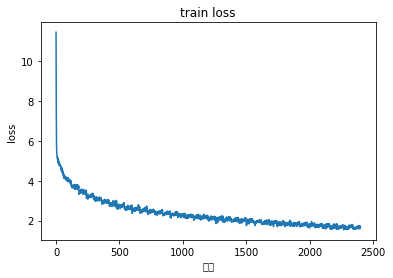

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## 以圖表呈現 檢驗 的 loss 變化趨勢

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


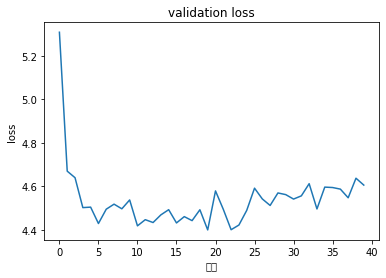

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

## BLEU score

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


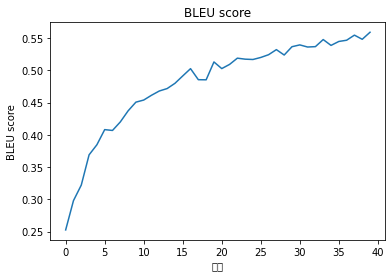

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('次數')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()